In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 


READ IN DATA

In [3]:
svm_df = pd.read_csv('./data/svm.csv',header=None)
lda_df = pd.read_csv('./data/lda.csv', header=None)

In [3]:
svm_df.head()

,0,1,2,3,4
0,600.0,0.5,0.0100,0.27620,191.980
1,900.0,0.8,0.1000,0.27420,99.976
2,2000.0,5.0,0.1000,0.27910,114.410
3,5000.0,1.0,0.0001,0.25770,748.726
4,1.0,5.0,0.0001,0.28714,1048.862


In [4]:
lda_df.head()

,0,1,2,3,4
0,1.0,4.0,16.0,2014.255351,36393.19
1,0.9,1024.0,4096.0,1680.540179,36419.51
2,0.6,1024.0,4096.0,1328.191297,24219.85
3,0.6,16.0,4.0,2859.440420,18862.01
4,0.7,1.0,4096.0,1313.263743,11218.42


### VISULAISE DATA

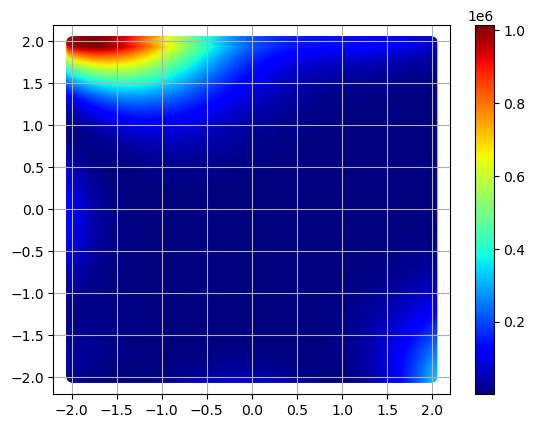

In [ ]:
x = np.linspace(-2,2,1000)
y = np.linspace(-2,2,1000)
x, y = np.meshgrid(x, y)

Z = (1+(x+y+1)**2*(19-14*x+3*x**2-14*y+6*x*y+3*y**2))*(30+(2*x-3*y)**2*(18-32*x+12*x**2+48*y-36*x*y+27*y**2))  

plt.scatter(x, y, c=Z, cmap='jet',vmin=Z.min(), vmax=Z.max())
plt.colorbar()
plt.grid()
plt.show()

<Figure size 640x480 with 0 Axes>

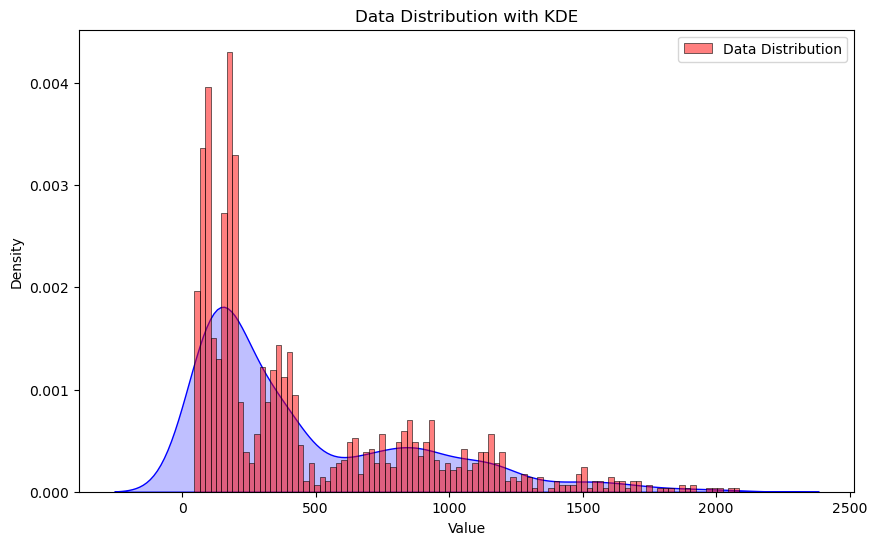

In [ ]:
from sklearn.neighbors import KernelDensity
import seaborn as sns

plt.figure("HISTOGRAM_SVM")


data = svm_df[4].to_numpy()

# Create the figure
plt.figure(figsize=(10, 6))
plt.title("Data Distribution with KDE")

# Plot the histogram of the data (distribution)
sns.kdeplot(data, fill=True, color='blue', label='KDE')
sns.histplot(data, kde=False, bins=100, color='red', stat='density', alpha=0.5, label="Data Distribution")

# Show the plot
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


<Figure size 640x480 with 0 Axes>

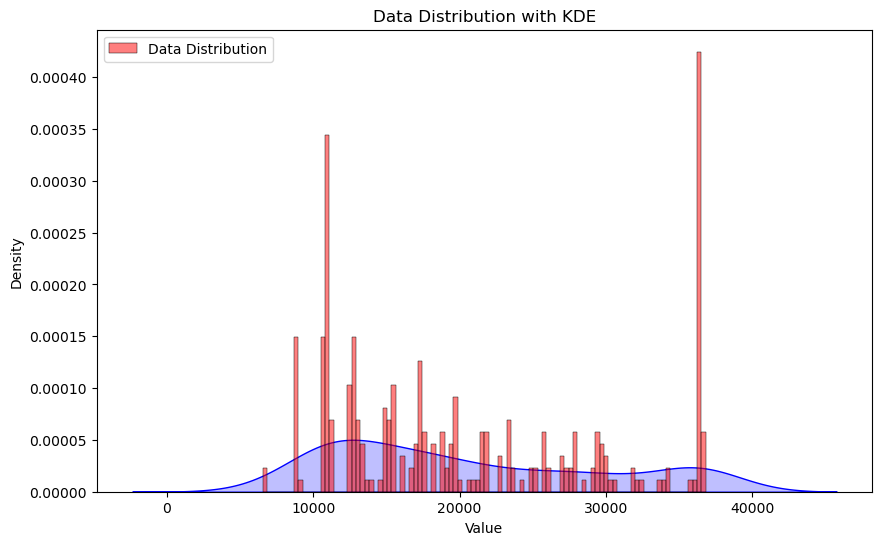

In [36]:
from sklearn.neighbors import KernelDensity
import seaborn as sns

plt.figure("HISTOGRAM_LDA")


data = lda_df[4].to_numpy()

# Create the figure
plt.figure(figsize=(10, 6))
plt.title("Data Distribution with KDE")

# Plot the histogram of the data (distribution)
sns.kdeplot(data, fill=True, color='blue')
sns.histplot(data, kde=False, bins=100, color='red', stat='density', alpha=0.5, label="Data Distribution")

# Show the plot
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


In [31]:
hist

(array([0.00694444, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.04513889, 0.00347222, 0.        ,
        0.        , 0.        , 0.        , 0.04513889, 0.10416667,
        0.02083333, 0.        , 0.        , 0.        , 0.03125   ,
        0.04513889, 0.02083333, 0.01388889, 0.00347222, 0.00347222,
        0.        , 0.00347222, 0.02430556, 0.02083333, 0.03125   ,
        0.        , 0.01041667, 0.        , 0.00694444, 0.01388889,
        0.03819444, 0.01736111, 0.        , 0.01388889, 0.        ,
        0.01736111, 0.00694444, 0.01388889, 0.02777778, 0.00347222,
        0.        , 0.00347222, 0.00347222, 0.00347222, 0.01736111,
        0.01736111, 0.        , 0.        , 0.01041667, 0.        ,
        0.02083333, 0.00694444, 0.        , 0.00347222, 0.        ,
        0.00694444, 0.00694444, 0.        , 0.01736111, 0.00694444,
        0.        , 0.        , 0.01041667, 0.00694444, 0.00694444,
        0.01736111, 0.        , 0.00347222, 0.  

In [29]:
max(kde_y)

5.014140550822201e-05